In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [3]:
data.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
data.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

## Data Selection

In [5]:
df = data[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

## EDA

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

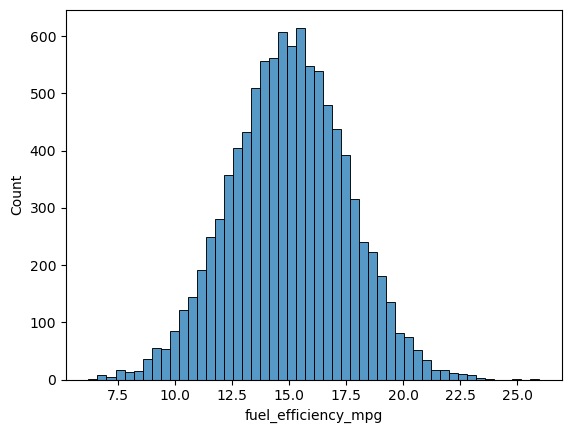

In [6]:
sns.histplot(df['fuel_efficiency_mpg'], bins=50)

## long tailed ?

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

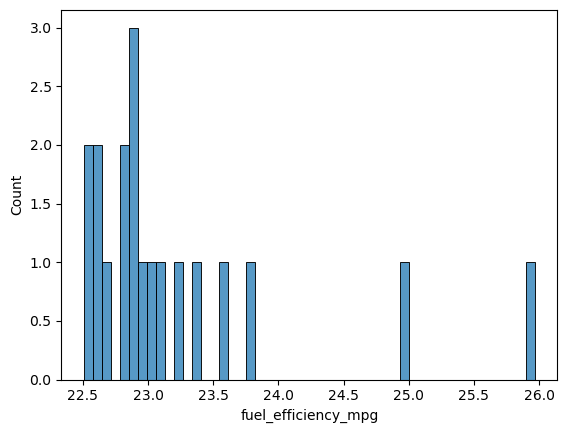

In [7]:
sns.histplot(df['fuel_efficiency_mpg'][df['fuel_efficiency_mpg'] > 22.5], bins=50)

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

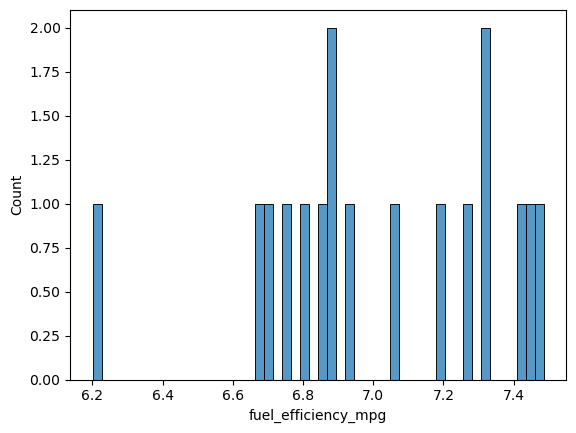

In [8]:
sns.histplot(df['fuel_efficiency_mpg'][df['fuel_efficiency_mpg'] < 7.5], bins=50)

## Question 1: Column with missing values 

In [9]:
df_nan = df.isnull().sum()
df_nan =[df_nan[df_nan.values > 0]]
df_nan

[horsepower    708
 dtype: int64]

## Question 2: Median horsepower

In [10]:
df['horsepower'].median()

149.0

In [11]:
def split_data_set(df, seed):
    n = len(df)
    indx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(indx)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    df_train = df.iloc[indx[:n_train]]
    df_val = df.iloc[indx[n_train:n_train+n_val]]
    df_test = df.iloc[indx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
    y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
    y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    return df_train, df_val, df_test, y_train, y_val, y_test
    

## Question 3: RMSE

In [13]:
np.random.seed(42)
np.random.shuffle(indx)

In [14]:
indx

array([ 483, 7506, 8795, ..., 5390,  860, 7270])

In [ ]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data_set(df, 42)

In [15]:
mean_hp = df_train['horsepower'].mean().round(2)
mean_hp

NameError: name 'df_train' is not defined

In [ ]:
def prepare_X(df, fillna_value):
    df = df.copy()
    df.horsepower = df.horsepower.fillna(fillna_value)
    return df
    

In [ ]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [ ]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [ ]:
X_train = prepare_X(df_train, 0)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, 0)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred).round(2)

In [ ]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

In [ ]:
X_train = prepare_X(df_train, mean_hp)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, mean_hp)
y_pred = w0 + X_val.dot(w)

rmse(y_val, y_pred).round(2)

In [ ]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

## Question 4: Regularized model

In [ ]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [ ]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

## Question 5: Random seeds test

In [ ]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_vals = []
for seed in seeds:
    df_train, df_val, df_test, y_train, y_val, y_test = split_data_set(df, seed)
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_pred)
    print('rmse_%s: '%seed, rmse_val)
    rmse_vals.append(rmse(y_val, y_pred))
 
rmse_vals
    
    

In [ ]:
np.std(np.array(rmse_vals)).round(3)

## Question 6: Seed 9 test on regularized model

In [ ]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data_set(df, 9)

df_merged = pd.concat([df_train, df_val])
y_merged = np.concatenate([y_train, y_val])

X_merged = prepare_X(df_merged, 0)
w0, w = train_linear_regression_reg(X_merged, y_merged, r=0.001)
X_test = prepare_X(df_test, 0)
y_pred = w0 + X_test.dot(w)
rmse_val = rmse(y_test, y_pred)
 
rmse_val
    
    